### git 管理

In [214]:
!git add ./1_画像を色データとして前処理して分析.ipynb

In [215]:
!git commit -m "自己組織化マップの追加とリファクタリング(まだできてない)"

[illust 655c95b] 自己組織化マップの追加とリファクタリング(まだできてない)
 1 file changed, 610 insertions(+)
 create mode 100644 "notebooks/1_\347\224\273\345\203\217\343\202\222\350\211\262\343\203\207\343\203\274\343\202\277\343\201\250\343\201\227\343\201\246\345\211\215\345\207\246\347\220\206\343\201\227\343\201\246\345\210\206\346\236\220.ipynb"


In [216]:
!git push

Counting objects: 4, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 175.51 KiB | 12.54 MiB/s, done.
Total 4 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/Intel0tw5727/info4dm-G4-popular-illust.git
   3a4d199..655c95b  illust -> illust


### ソースコード

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

plt.style.use("ggplot")

In [107]:
img = cv2.imread("../data/download_image_monthly/20171024/full/7ea5ecd63f7fa6627a6ba95559f5e288bbe45d40.jpg")
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

(-0.5, 564.5, 799.5, -0.5)

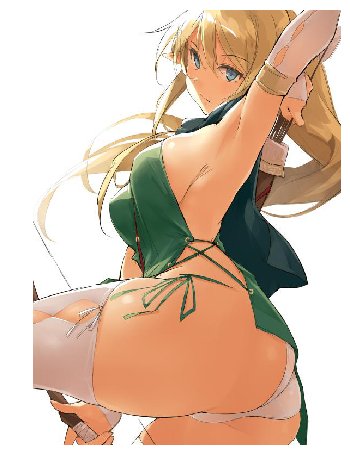

In [108]:
plt.figure(figsize=(12,8))
plt.imshow(img_rgb)
plt.axis("off")

RGBそれぞれについてcountをするために、画像を崩して前処理

In [4]:
c_data = img_hsv.reshape(-1, 3)

In [6]:
df = pd.DataFrame(c_data, columns=["Hue", "Saturation", "Value"])

HSV分析

SOMをつかって似た色をまとめた画像を作っていく

### 自己組織化マップ

In [95]:
class SOM():

    def __init__(self, teachers, N, seed=None):
        self.teachers = np.array(teachers).reshape(-1,3)
        self.n_teacher = self.teachers.shape[0]
        self.N = N
        if not seed is None:
            np.random.seed(seed)

        x, y = np.meshgrid(range(self.N), range(self.N))
        self.c = np.hstack((y.flatten()[:, np.newaxis],
                            x.flatten()[:, np.newaxis]))
        self.nodes = np.random.rand(self.N*self.N,
                                    self.teachers.shape[1])

    def train(self):
        for i, teacher in enumerate(self.teachers):
            bmu = self._best_matching_unit(teacher)
            d = np.linalg.norm(self.c - bmu, axis=1)
            L = self._learning_ratio(i)
            S = self._learning_radius(i, d)
            self.nodes += L * S[:, np.newaxis] * (teacher - self.nodes)
        return self.nodes

    def _best_matching_unit(self, teacher):
        #compute all norms (square)
        norms = np.linalg.norm(self.nodes - teacher, axis=1)
        bmu = np.argmin(norms) #argment with minimum element 
        return np.unravel_index(bmu,(self.N, self.N))

    def _neighbourhood(self, t):#neighbourhood radious
        halflife = float(self.n_teacher/4) #for testing
        initial  = float(self.N/2)
        return initial*np.exp(-t/halflife)

    def _learning_ratio(self, t):
        halflife = float(self.n_teacher/4) #for testing
        initial  = 0.1
        return initial*np.exp(-t/halflife)

    def _learning_radius(self, t, d):
        # d is distance from BMU
        s = self._neighbourhood(t)
        return np.exp(-d**2/(2*s**2))

### SOMに通す前の前処理
+ 画像サイズを大きすぎないようにリサイズ
+ 自己組織化マップ用に画像の数値を正規化

In [109]:
# リサイズ
n = 2
img_rgb = cv2.resize(img_rgb, (img.shape[1]//n, img.shape[0]//n))
# 正規化
img_rgb_norm = img_rgb / np.linalg.norm(img_rgb) * 255

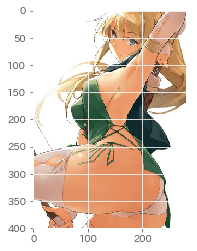

In [119]:
plt.imshow(img_rgb)

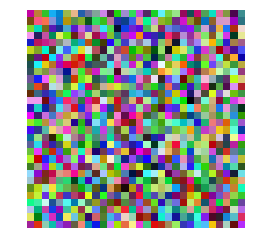

array([[ 0.57327679,  0.57327679,  0.57327679],
       [ 0.57327676,  0.57327669,  0.57327663],
       [ 0.57323791,  0.57324232,  0.57311102],
       ..., 
       [ 0.51303692,  0.31207971,  0.21318839],
       [ 0.51599895,  0.3116626 ,  0.21343787],
       [ 0.5213517 ,  0.31006293,  0.2139112 ]])

In [117]:
n = 30
som = SOM(np.random.permutation(img_rgb_norm), N=n,  seed=10)

# Initial map
plt.imshow(som.nodes.reshape(n,n,3),
           interpolation='none')
plt.axis("off")
plt.show()

# Train
som.train()

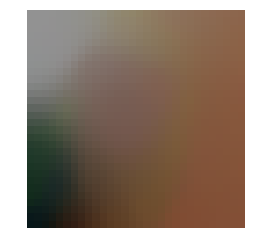

In [118]:
# Trained MAP
plt.imshow(som.nodes.reshape(n,n,3),
           interpolation='none')
plt.axis("off")
plt.show()

In [130]:
som.nodes.reshape(-1,3).T

array([[ 0.57327679,  0.57327676,  0.57323791, ...,  0.51303692,
         0.51599895,  0.5213517 ],
       [ 0.57327679,  0.57327669,  0.57324232, ...,  0.31207971,
         0.3116626 ,  0.31006293],
       [ 0.57327679,  0.57327663,  0.57311102, ...,  0.21318839,
         0.21343787,  0.2139112 ]])

somで生成した画像をHSV変換して簡単な段階(Hを30毎)でまとめてcountする

In [153]:
df1 = pd.DataFrame(som.nodes.reshape(-1,3)*255)

In [158]:
df1 = df1.apply(lambda x: round(x,-1))

In [160]:
df1.groupby([0,1])[2].value_counts().sort_values(ascending=False)

0      1      2    
140.0  90.0   60.0     65
150.0  150.0  150.0    50
140.0  100.0  70.0     39
       110.0  80.0     36
       100.0  80.0     30
120.0  100.0  90.0     24
140.0  90.0   70.0     24
130.0  80.0   60.0     23
120.0  90.0   60.0     23
140.0  80.0   60.0     22
130.0  110.0  100.0    20
120.0  90.0   80.0     19
130.0  100.0  90.0     18
140.0  120.0  90.0     17
130.0  100.0  80.0     17
140.0  110.0  90.0     17
130.0  90.0   60.0     16
       100.0  70.0     15
110.0  80.0   50.0     14
140.0  120.0  100.0    13
110.0  80.0   60.0     13
120.0  80.0   50.0     11
140.0  140.0  140.0    11
100.0  80.0   60.0     11
150.0  150.0  140.0    10
120.0  90.0   70.0     10
140.0  130.0  120.0     9
40.0   60.0   50.0      9
150.0  140.0  120.0     9
120.0  100.0  80.0      8
                       ..
150.0  120.0  90.0      1
140.0  150.0  150.0     1
              140.0     1
       110.0  100.0     1
120.0  130.0  120.0     1
       120.0  120.0     1
       100.0  100.

In [50]:
df.groupby(["Hue", "Saturation"])["Value"].value_counts().head()

Hue  Saturation  Value
0    0           21       229
                 58       217
                 56       197
                 19       191
                 57       178
Name: Value, dtype: int64

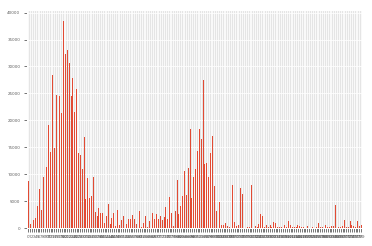

In [6]:
df["Hue"].value_counts().sort_index().plot(kind="bar", rot=0, fontsize=4)

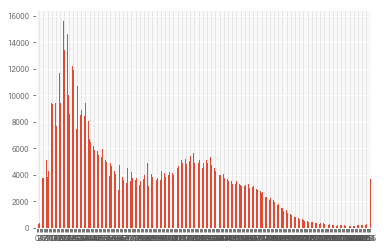

In [18]:
df["Saturation"].value_counts().sort_index().plot(kind="bar", rot=0, fontsize=7)

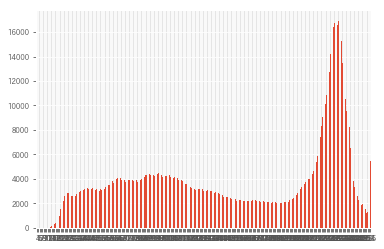

In [19]:
df["Value"].value_counts().sort_index().plot(kind="bar", rot=0, fontsize=7)

In [20]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

(-0.5, 1199.5, 799.5, -0.5)

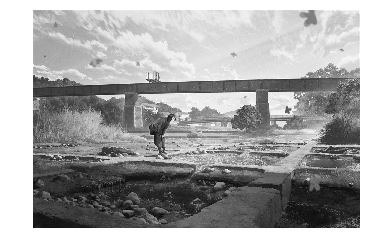

In [24]:
plt.imshow(gray_img, cmap="gray")
plt.axis("off")

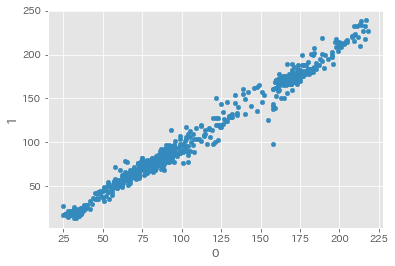

In [30]:
pd.DataFrame(gray_img).plot(kind="scatter",x=0, y=1)

meta.jsonを読み込む

In [ ]:
df = pd.read_csv("../data/download_image_monthly/20171024/meta.json", delimiter="\n", header=None)

In [ ]:
import json
meta_tags = []
#meta = json.loads(df.iloc[i].values[0])
for i in df.index:
    meta = json.loads(df.iloc[i].values[0])
    meta_tags.append(meta["tags"])

In [ ]:
meta_tags

?を置換する

In [ ]:
test = pd.read_csv("../../Automobile price data _Raw_.csv")

In [ ]:
test.replace("?", np.NaN)

In [ ]:
df=pd.DataFrame({"age": ["?", "?", "?"],
                "height": ["?", "?", "?"],
                "weight": ["?", "?", "?"]})

In [ ]:
df.replace("?", np.NaN)